In [1]:
import numpy as np
import pandas as pd
from matminer.featurizers.composition import ElementProperty, Stoichiometry 
from matminer.featurizers.composition import ValenceOrbital, IonProperty, AtomicOrbitals
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer

from matminer.featurizers.conversions import DictToObject, StrToComposition
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from pymatgen.core.composition import Composition

## Loading data and featurizing compositions

In [2]:
df_train=pd.read_csv('data/roost_data/train.csv',usecols=['formula', 'disorder'])
df_test=pd.read_csv('data/roost_data/test.csv',usecols=['formula', 'disorder'])
df_train.head(5)

,formula,disorder
0,Ce0.8 Cu2.38 Nd1.78 O10 Ru0.62 Sr1.42,1
1,Co3 Cu3 O12 Te2,1
2,H12 Mn1 N2 O10 S2,0
3,Ge13 Pr3 Pt4,0
4,Ni1 O4 Tc1 Zn1,1


In [3]:
df_train['composition']=[Composition(df_train.iloc[i]['formula']).fractional_composition for i in range(len(df_train))]
df_test['composition']=[Composition(df_test.iloc[i]['formula']).fractional_composition for i in range(len(df_test))]

In [4]:
featurizer = MultipleFeaturizer([
    ElementProperty.from_preset('magpie'),
    Stoichiometry(),
    ValenceOrbital()
])
flen=len(featurizer.featurize(df_train['composition'][0]))
features_train=np.zeros((len(df_train),flen))
features_test=np.zeros((len(df_test),flen))
for i,comp in enumerate(df_train['composition']):
    features_train[i,:]=featurizer.featurize(comp)
for i,comp in enumerate(df_test['composition']):
    features_test[i,:]=featurizer.featurize(comp)
features_train=np.nan_to_num(features_train, copy=True, nan=0.0, posinf=None, neginf=None)
features_test=np.nan_to_num(features_test, copy=True, nan=0.0, posinf=None, neginf=None)

C:\Users\patykova\.conda\envs\roost\lib\site-packages\pymatgen\core\periodic_table.py:212: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [8]:
ytrain=df_train['disorder'].values
ytest=df_test['disorder'].values
Xtrain=features_train
Xtest=features_test

In [9]:
from sklearn.metrics import f1_score,balanced_accuracy_score, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

balanced_accuracy=[]
f1=[]
precision=[]
recall=[]
roc_auc=[]
mc=[]
test_size=0.2
y_pred_array=np.zeros((10,len(df_test)))
y_score_array=np.zeros((10,len(df_test)))

for i in range(42,42+10):
    RF=RandomForestClassifier()
    RF.fit(Xtrain,ytrain)
    ypred=RF.predict(Xtest)
    yproba=RF.predict_proba(Xtest)[:,1]
    y_pred_array[i-42,:]=ypred
    y_score_array[i-42,:]=yproba
    f1.append(f1_score(ytest,ypred))
    precision.append(precision_score(ytest,ypred))
    recall.append(precision_score(ytest,ypred))
    roc_auc.append(roc_auc_score(ytest,yproba))
    balanced_accuracy.append(balanced_accuracy_score(ytest,ypred))
    mc.append(matthews_corrcoef(ytest,ypred))

In [61]:
mean_f1=np.mean(f1)
std_f1=np.std(f1)
mean_f1, std_f1

(0.8940420489541415, 0.002422073812458716)

In [63]:
mean_precision=np.mean(precision)
std_precision=np.std(precision)
mean_precision, std_precision

(0.8979366543308489, 0.003379930847316524)

In [64]:
mean_recall=np.mean(recall)
std_recall=np.std(recall)
mean_recall, std_recall

(0.8979366543308489, 0.003379930847316524)

In [65]:
mean_auc=np.mean(roc_auc)
std_auc=np.std(roc_auc)
mean_auc, std_auc

(0.9423912601567404, 0.0014121001339331672)

In [66]:
mean_ba=np.mean(balanced_accuracy)
std_ba=np.std(balanced_accuracy)
mean_ba, std_ba

(0.8684406813879516, 0.0027268939296209325)

In [67]:
mean_mc=np.mean(mc)
std_mc=np.std(mc)
mean_mc, std_mc

(0.7352973420247746, 0.005143997740694817)

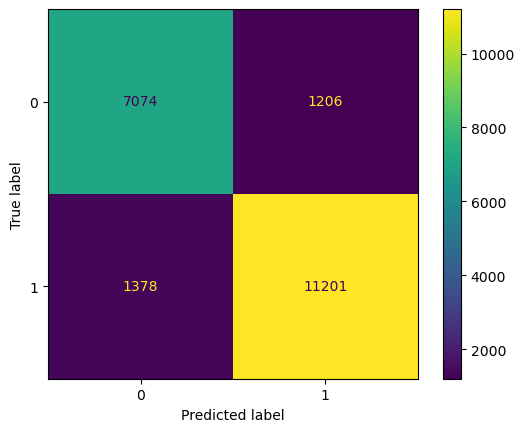

In [62]:
cfm=confusion_matrix(ytest,ypred)
disp=ConfusionMatrixDisplay(cfm)
disp.plot()
plt.show()

In [68]:
cfm

array([[ 7074,  1206],
       [ 1378, 11201]])